In [1]:
# Imports from provided example notebook
import numpy as np
import matplotlib.pyplot as plt
import batman

# Additionally import astropy for physical constants
import astropy.constants as ac

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from cycler import cycler

# Define custom colors in matplotlib for our plots. The color palette
# is manually tuned from one generated on coolors.co
colors_map = matplotlib.colors.get_named_colors_mapping()
colors_map.cache.clear()
colors_map.update({
    "custom:primary": "#262626",
    "custom:secondary": "#dfac29",
    "custom:highlight": colors_map["tab:red"]
})

# Set some nice plotting defaults. These have been built up from the past
# two lab assignments
CUSTOM_PLOT_STYLE = {
    "text.usetex": True,

    "font.family": "serif",
    "font.size": 16,

    # Set some default sizes, so we don't need to include them in each call
    "lines.markersize": 5,
    "lines.linewidth": 1.5,
    # "errorbar.capsize": 3,

    # Set savefig to use bbox_inches="tight" by default
    "savefig.bbox": "tight",
    "savefig.facecolor": "none",
    "savefig.dpi": 300,

    # Use our custom defined colors by default
    "axes.prop_cycle": cycler(color=("custom:primary", "custom:secondary",)),

    # Higher DPI for sharper inline images
    "figure.dpi": 96
}

matplotlib.rcdefaults()
matplotlib.rcParams.update(CUSTOM_PLOT_STYLE)

In [3]:
# Define some properties of the transit reported from the literature (Jenkins+ 2015)
P_literature = 384.843 # transit period [days]
tau_literature = 54833 + 314.98 # first transit midpoint [mjd]
T_literature = 10.63/24.0 # transit duration [days]

In [4]:
# Define a set of test parameters [use values from Jenkins+]
theta=np.empty([5])
theta[0] = 0.0128          # Rp/Rstar
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter
theta[3] = P_literature    # orbital period
theta[4] = tau_literature  # transit mid-point

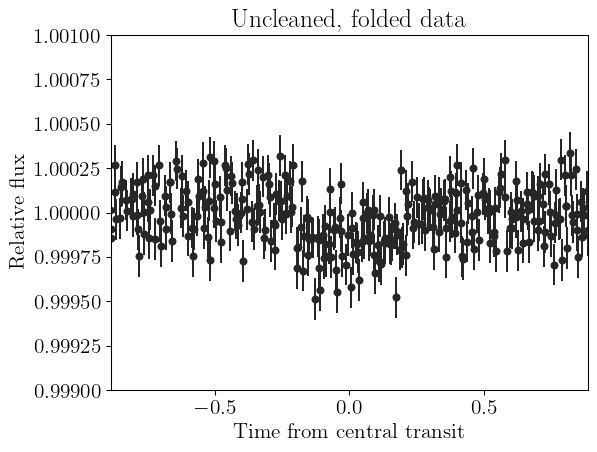

In [5]:
# Load in the data directly into three arrays (using unpack=True)
tobs, fobs, sigfobs = np.genfromtxt("lightcurve.dat", dtype=None, unpack=True)

# Fold the time array by periods using the literature reported transit properties
tobsfolded = tobs - tau_literature - P_literature * np.round((tobs-tau_literature)/P_literature)

fig, ax = plt.subplots()
ax.errorbar(tobsfolded, fobs, yerr=sigfobs, fmt="o")
ax.set_title("Uncleaned, folded data")
ax.set_xlabel('Time from central transit')
ax.set_ylabel('Relative flux')
ax.set_xlim(-2*T_literature, +2*T_literature)
ax.set_ylim(0.999,1.001)

plt.show()

Can we do better? Perform outlier removal + non-parametric detrending

In [6]:
# Make sure the data we have is time-sorted first
assert np.all(np.diff(tobs) >= 0.)

# Define a pivot time to constrain the size of the times
t_pivot = np.median(tobs)
tau_literature_pivoted = tau_literature - t_pivot
tpobs = tobs - t_pivot # new time array
print("t_pivot:", t_pivot)

# Divide the data into the four large windows, so we don't have windows spanning
# a large gap in observations
# Cut out the first point because it's a horrible data point
obs_start = (1, *(1 + np.where(np.diff(tpobs) > 10.0)[0]), len(tpobs))
# and this line pairs them together into window beginning and end indices.
obs_windows = list(zip(obs_start[:-1], obs_start[1:]))
print("obs_windows:", obs_windows)

t_pivot: 55842.586295539986
obs_windows: [(1, 3736), (3736, 7472), (7472, 11243), (11243, 15301)]


In [7]:
# Outlier removal
outlier_mask = np.zeros(len(tpobs), dtype=bool)

for iS, iF in obs_windows:
    # We use a five point bandwidth, so we don't evaluate the first two and last two points.
    # in each window
    for i in range(iS+2, iF-2):
        # Calculate the median of the five points
        med = np.median(fobs[i-2:i+3])
        # Checks if the central point is more than 3-sigma away from the median
        if abs(fobs[i] - med) / sigfobs[i] > 3:
            outlier_mask[i] = True

# Manually remove the first point which is an extreme outlier
outlier_mask[0] = True

print(f"Found: {np.sum(outlier_mask)} outliers out of {len(tpobs)} points")

Found: 182 outliers out of 15301 points


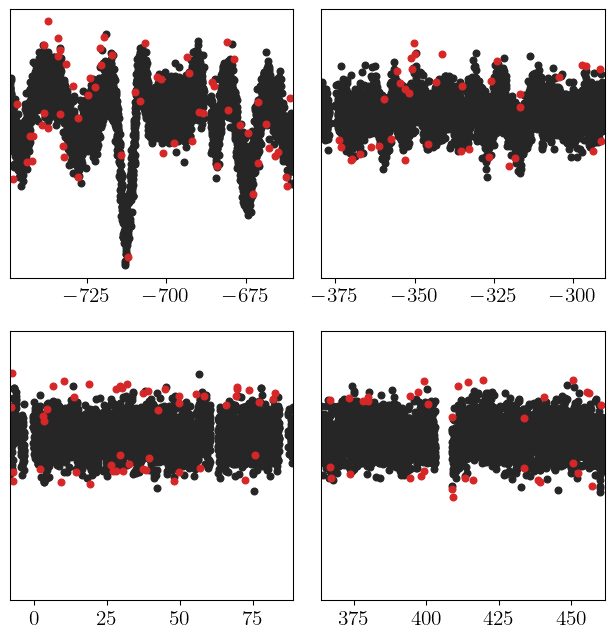

In [8]:
# Make closer up plots of each window, to visually inspect that we're not missing
# obvious outliers. This plot isn't included on the slides

# Create a grid of 4 plots, 1 for each window
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(8, 8))
# Decreases the horizontal spacing between the the windows
fig.subplots_adjust(wspace=0.1)

for w in range(4):
    ax = axs.ravel()[w]

    # With errorbars the plots are very noisy, preventing us from seeing individual points
    # We opt for a scatter here instead
    ax.scatter(tpobs[~outlier_mask], fobs[~outlier_mask])
    ax.scatter(tpobs[outlier_mask][1:], fobs[outlier_mask][1:], color="custom:highlight")

    ax.set_xlim(tpobs[obs_windows[w][0]], tpobs[obs_windows[w][1]-1])
    
    ax.set_yticks([])

plt.show()

In [9]:
# Use a time-windowed median for detrending.

# Make our window five times the transit duration
window_size = T_literature * 3.

# New array representing the trend at each observation point
ftrend = np.full_like(fobs, np.nan)

for iS, iF in obs_windows:
    tS = tpobs[iS]
    tF = tpobs[iF-1]

    for i in range(iS, iF):
        # Get the time window around the point
        twS = tpobs[i] - window_size / 2.
        twF = tpobs[i] + window_size / 2.

        # Skip if we're on the edges of the observation window
        if twS < tS or twF > tF:
            continue

        # Get the slice of points inside the window
        # Extremely inefficient method, but good enough for us
        tw_mask = np.logical_and(twS < tpobs, tpobs < twF)
        ftrend[i] = np.median(fobs[tw_mask])

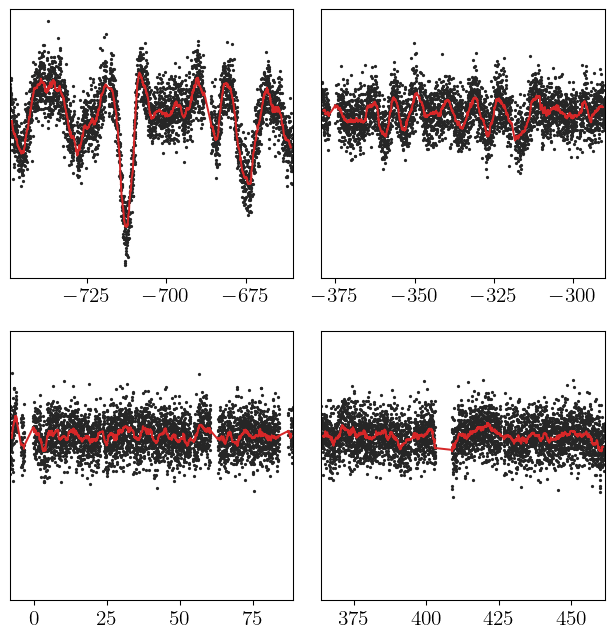

In [171]:
# Make closer up plots of each window, to visually inspect that out trend line makes sense

# Create a grid of 4 plots, 1 for each window
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(8, 8))
# Decreases the horizontal spacing between the the windows
fig.subplots_adjust(wspace=0.1)

for w in range(4):
    ax = axs.ravel()[w]

    # Plot the observation data in black
    ax.scatter(tpobs[1:], fobs[1:], s=2)
    # Plot our trend in the highlight color
    ax.plot(tpobs[1:], ftrend[1:], color="custom:highlight")

    # Set the limits according to the observation window/quarter
    ax.set_xlim(tpobs[obs_windows[w][0]], tpobs[obs_windows[w][1]-1])
    
    ax.set_yticks([])

plt.show()

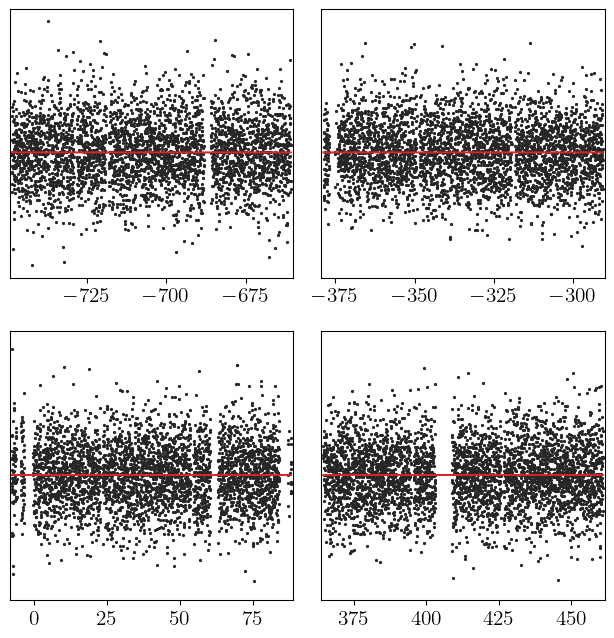

In [172]:
# Make closer up plots of each window, to visually inspect that out trend line makes sense

# Create a grid of 4 plots, 1 for each window
fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(8, 8))
# Decreases the horizontal spacing between the the windows
fig.subplots_adjust(wspace=0.1)

for w in range(4):
    ax = axs.ravel()[w]

    # Plot the observation data in black
    ax.scatter(tpobs[1:], (fobs/ftrend)[1:], s=2)
    # Plot our trend in the highlight color
    ax.plot(tpobs[1:], (ftrend/ftrend)[1:], color="custom:highlight")

    # Set the limits according to the observation window/quarter
    ax.set_xlim(tpobs[obs_windows[w][0]], tpobs[obs_windows[w][1]-1])
    
    ax.set_yticks([])

plt.show()

In [17]:
# Use Dan Foreman-Mackey's emcee package for the actual MCMC because
# we're unable to achieve good results with a very simplistic proposal
# algorithm

import emcee
import numba
from functools import partial

jit = partial(numba.jit, forceobj=True)

def log_likelihood_chi2(model, x, y, sigma_y, *args):
    """Factory for the generic chi^2 likelihood function

    Returns a Numba jit'd function taking some input parameters and evaluates
    log(P(theta | D)) the log likelihood of the parameters theta based on the
    observed data (x, y, sigma_y). Output is improper.

    Args:
        model (factory_function): A factory function that takes in the array x
        and returns a function that models y at each x based on the parameters
        theta.
        x (array_like): Observation data x.
        y (array_like): Observation data y (is compared with model). Has the
        same dimensions as x.
        sigma_y (array_like): Uncertainty of observations. Has the same
        dimensions as x.
    """    

    _model = model(x, y, sigma_y, *args)

    # this factor is constant in the denominator
    two_sigma_y2 = 2*(sigma_y**2)

    @jit
    def _log_likelihood_chi2(theta):
        return -np.sum((y - _model(theta))**2 / two_sigma_y2)

    return _log_likelihood_chi2

def log_mul2(fn1, fn2):
    """Take the product of two functions returning log probabilities.

    Assumes the input functions are wrapped with @numba.jit.

    Useful for creating a probability function from a likelihood and prior.
    """

    @jit
    def _log_mul2(theta):
        return fn1(theta) + fn2(theta)
    return _log_mul2

In [18]:
Grv = ac.G.value # m^3 / kg / s^2

# This function is split out because we need to use it to initialize the parameters
@jit
def update_params(theta, params):
    # Calculations from sample notebook
    rp, logrho, impact = theta
    rhostar = np.power(10.0,logrho)
    aR = np.power((Grv*(params.per*86400.0)**2*rhostar )/(3.0*np.pi), 0.33333333)
    incdeg = (180.0/np.pi)*np.arccos(impact/aR)

    # Modify the parameters we want to change for batman
    params.rp = rp
    params.a = aR # a/R_star
    params.inc = incdeg # orbital inclination (degrees)


def batman_model(x, y, sigma_y, params):
    m = batman.TransitModel(params, x, supersample_factor=30, exp_time=0.020434)

    @jit
    def _batman_model(theta):
        update_params(theta, params)

        # Return the light curve from batman
        return m.light_curve(params)
    return _batman_model

In [119]:
rhostar = np.power(10.0, 2.9)
aR = np.power((Grv*(params.per*86400.0)**2*rhostar )/(3.0*np.pi), 0.33333333)
impact = 0.4
(180.0/np.pi)*np.arccos(impact/aR)

89.87537459936716

In [108]:
np.sum(outlier_mask) / outlier_mask.shape[0]

0.0118946474086661

In [121]:
# Do an MCMC fit on the detrended data
params = batman.TransitParams()

params.per = P_literature
params.t0 = tau_literature

# Set the fixed model parameters
params.ecc = 0.0                    #eccentricity
params.w = 90.                      #longitude of periastron (degrees)
params.limb_dark = "quadratic"      #limb darkening model--other choices include quadratic, etc.
# Coefficients for a nonlinear limb darkening law.
params.u = [0.459196, 0.2248176]

# Initialize our model with the values from Jenkins+ 2015
theta = np.empty(3)
theta[0] = 0.0128          # Rp/Rstar
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter

update_params(theta, params)

fit_window = (-2*T_literature < tobsfolded) & (tobsfolded < 2*T_literature)
x = tobs[fit_window]
y = (fobs / ftrend)[fit_window]
sigma_y = (sigfobs / ftrend)[fit_window]

assert np.all([np.isfinite(x), np.isfinite(y), np.isfinite(sigma_y)])

# Make sure our model works with a set of test parameters [values from Jenkins+ 2015]
theta = np.empty(3)
theta[0] = 0.0128          # Rp/Rstar
theta[1] = 3.306           # log(rho* [kg/m3])
theta[2] = 0.69            # b impact parameter

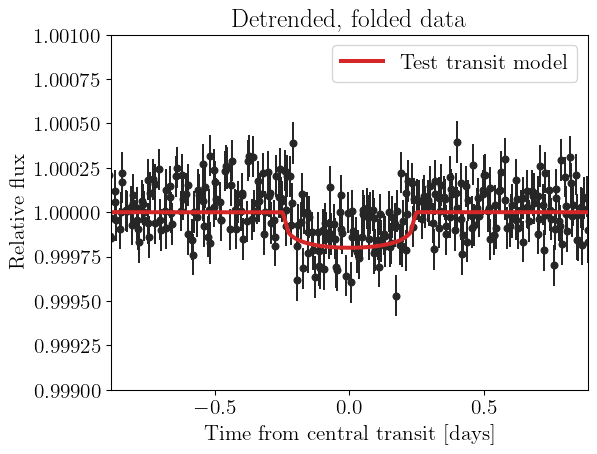

In [113]:
# Plot the folded data again, this time after detrending
fig, ax = plt.subplots()

ax.errorbar(tobsfolded, fobs/ftrend, yerr=sigfobs/ftrend, fmt="o", zorder=-1)
# ax.errorbar(tobsfolded[outlier_mask], (fobs/ftrend)[outlier_mask], yerr=(sigfobs/ftrend)[outlier_mask], fmt="ro", zorder=0)

# Temporarily modify params for a single transit around 0
params.t0 = 0.
test_model_ts = np.linspace(-2*T_literature, +2*T_literature, 1000)
test_model = batman_model(test_model_ts, None, None, params)(_theta)
params.t0 = tau_literature

ax.plot(test_model_ts, test_model, color="custom:highlight", lw=3, zorder=1, label="Test transit model")

ax.set_title("Detrended, folded data")
ax.set_xlabel('Time from central transit [days]')
ax.set_ylabel('Relative flux')
ax.legend()
ax.set_xlim(-2*T_literature, +2*T_literature)
ax.set_ylim(0.999,1.001)

plt.savefig("model_test.pdf")
plt.show()

In [32]:
import emcee

# Start the walkers around the known solution from literature (borrowed from emcee docs)
initial_guesses = theta + 1e-4 * np.random.randn(8, 3)
nwalkers, ndim = initial_guesses.shape

log_prob_model = log_mul2(
    log_likelihood_chi2(batman_model, x, y, sigma_y, params),
    # apply a prior preventing negative b
    lambda theta: 0 if theta[2] >= 0. else -np.inf
)

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_prob_model
)
sampler.run_mcmc(initial_guesses, 1024 * 64, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 65536/65536 [13:27<00:00, 81.15it/s]


In [34]:
sampler.get_autocorr_time()

array([770.9970539 , 929.86310633, 589.32061785])

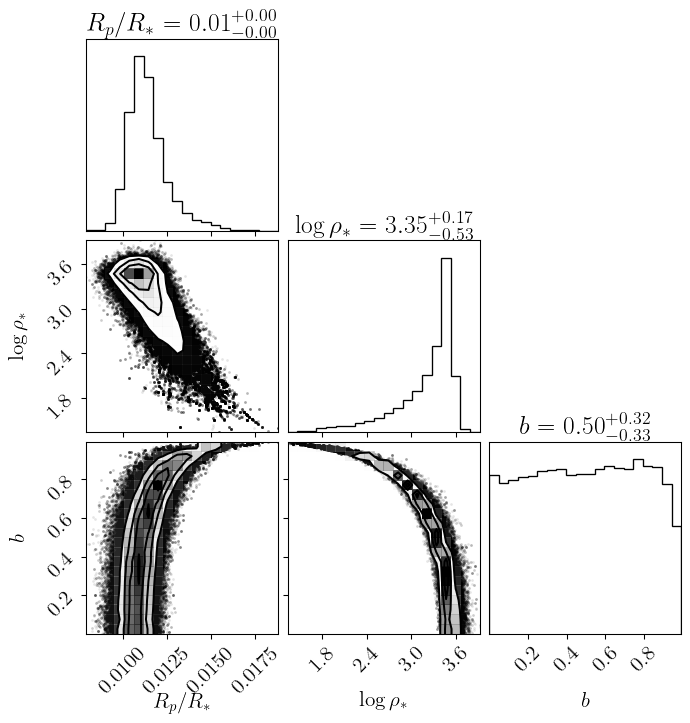

In [136]:
import corner

mcmc_samples = sampler.get_chain(flat=True, discard=1000)
corner.corner(mcmc_samples, show_titles=True, labels=[r"$R_p / R_\ast$", r"$\log \rho_\ast$", r"$b$"])

plt.savefig("corner.pdf")
plt.show()

In [137]:
1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2)

array([0.1175031 , 0.39346934, 0.67534753, 0.86466472])

In [38]:
# Use a Monte Carlo method to get a joint posterior for R_p and T_p

# Load the samples for the stellar parameters
stellar_samples = np.genfromtxt("kplr008311864_dr25-stellarposterior.txt", skip_header=4)
print(f"Loaded {len(stellar_samples)} samples for Tstar and Rstar")

Loaded 40000 samples for Tstar and Rstar


In [42]:
# Pull a million samples to make our posterior for Rp and Tp
N = 1000000
# Get N random samples (in the form of indices) from the MCMC results
mcmc_subset = np.random.choice(mcmc_samples.shape[0], N)
# Get N random samples (in the form of indices) from the stellar posterior
stellar_subset = np.random.choice(stellar_samples.shape[0], N)

In [142]:
import astropy.units as au

# Calculate aR, the semi-major axis of the planet in stellar radii,
# the same way we did in the MCMC model
rhostar = np.power(10., mcmc_samples[mcmc_subset, 1])
aR = np.power((Grv*(P_literature*86400.0)**2*rhostar)/(3.0*np.pi), 0.33333333)
# Calculate Tp, the effective temperature of the planet,
# using the formula Tp = Tstar * sqrt(Rstar/(2*a))
Tp = stellar_samples[stellar_subset, 0] * (2*aR)**(-1/2)

Rfactor = 1.1 / 0.8 # corrective factor to stellar radius from DR25 (see paper)
# Calculate Rp, the radius of the planet
_Rp = stellar_samples[stellar_subset, 4] * mcmc_samples[mcmc_subset, 0] * Rfactor
# Convert from solar radii to earth Radii
Rp = (_Rp * au.R_sun).to_value(au.R_earth)

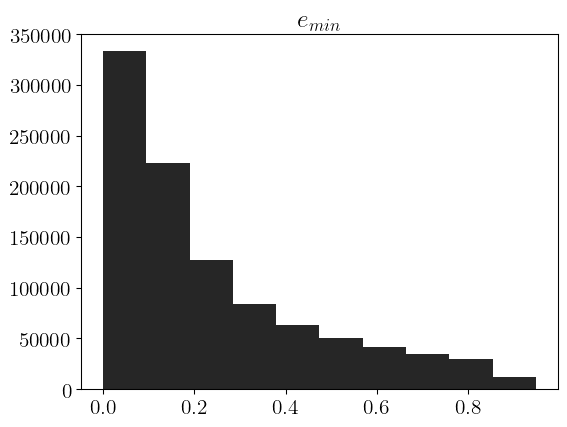

In [166]:
_rho_dr25 = (stellar_samples[stellar_subset, 3] * au.M_sun) / (Rfactor * stellar_samples[stellar_subset, 4] * au.R_sun)**3
rho_dr25 = _rho_dr25.to_value(au.kg / au.m**3)
emin = np.abs(1-(rhostar/rho_dr25)**(2/3)) / (1+(rhostar/rho_dr25)**(2/3))
plt.hist(emin)
plt.title("$e_{min}$")
plt.show()

In [156]:
Habitable = (207.5 < Tp) & (Tp < 320.4)
Rocky = (Rp < 1.23)
print(np.sum(Habitable & Rocky)/1e6, np.sum(~Habitable & Rocky)/1e6, np.sum(Rocky)/1e6)
print(np.sum(Habitable & ~Rocky)/1e6, np.sum(~Habitable & ~Rocky)/1e6, np.sum(~Rocky)/1e6)
print(np.sum(Habitable)/1e6, np.sum(~Habitable)/1e6, len(Habitable)/1e6)

0.132036 0.000619 0.132655
0.753602 0.113743 0.867345
0.885638 0.114362 1.0


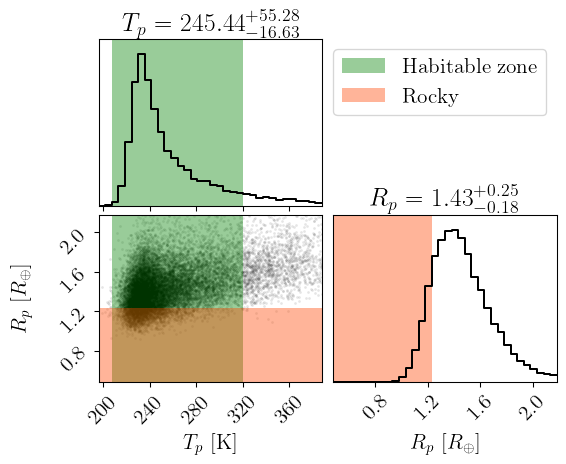

In [167]:
fig = plt.figure()

# Make the bins for the temperature histogram, such that we have borders at the habitable zone boundaries
Tbinwidth = (320.4 - 207.5) / 20
# This will create 24 bins
Tbins = np.arange(207.5 - 2*Tbinwidth, 390, Tbinwidth)

# Make the bins for the radius histogram, such that we have a border at the boundary
Rbinwidth = 0.05
Rbins = np.arange(1.23 - 15*Rbinwidth, 1.23 + 20*Rbinwidth, Rbinwidth)

corner.corner(
    np.vstack([Tp[::50], Rp[::50]]).T,
    bins=[Tbins, Rbins],
    plot_datapoints=True, show_titles=True,
    plot_contours=False, plot_density=False,
    labels=[r"$T_p$", r"$R_p$"],
    smooth1d=0.,
    fig=fig
)

fig.axes[0].set_xlim(Tbins[0], Tbins[-1])
fig.axes[0].set_ylim(0.0, fig.axes[0].get_ylim()[1])
fig.axes[0].axvspan(207.5, 320.4, ec="none", fc="green", alpha=0.4)

fig.axes[2].set_xlim(Tbins[0], Tbins[-1])
fig.axes[2].set_ylim(Rbins[0], Rbins[-1])
hh = fig.axes[2].axvspan(207.5, 320.4, ec="none", fc="green", alpha=0.4, label="Habitable zone")
rh = fig.axes[2].axhspan(Rbins[0], 1.23, ec="none", fc="orangered", alpha=0.4, label="Rocky")
fig.axes[2].set_ylabel(r"$R_p$ [$R_\oplus$]")
fig.axes[2].set_xlabel(r"$T_p$ [K]")

fig.axes[3].set_xlim(Rbins[0], Rbins[-1])
fig.axes[3].set_ylim(0.0, fig.axes[3].get_ylim()[1])
fig.axes[3].axvspan(Rbins[0], 1.23, ec="none", fc="orangered", alpha=0.4)
fig.axes[3].set_xlabel(r"$R_p$ [$R_\oplus$]")

fig.axes[1].legend(handles=[hh, rh])


plt.savefig("zone.pdf")

plt.show()

In [71]:
# Make a joint posterior for emin using the equation from the 

35